In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from math import floor

import matplotlib.pyplot as plt

from ml_utils import custom_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print(device)

cuda:0


In [2]:
def get_accuracy(curr_net, data_loader):
    """
    Use trainloader for train accuracy
    Use testloader for test accuracy
    """
    l1_diff_sum = 0
    n_samples = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            # This is so that the shape would match. Otherwise, the in_accuracy might be > 1
            labels = labels.view(labels.size(0), 1)

            outputs = curr_net(images)
            # since we know our output is between 0 to 1
            outputs = torch.clamp(outputs, min=0, max=1)
            # outputs will be one batch at a time, i.e. shape of [batch_size, 1]
            # print("accu output shapoe", outputs.shape)
            l1_diff_sum += torch.sum(torch.abs(outputs - labels))
            n_samples += labels.size(0)

    return l1_diff_sum / n_samples

def train(curr_net, curr_optimizer, graph_title, num_epoch=5, print_interval=2000):
    train_accu = []
    test_accu = []
    print('HI')
    # reduce precision
    curr_net = curr_net.float()
    for epoch in range(num_epoch):
        running_loss = 0.0
        print('Epoch', epoch)
        for i, data in enumerate(trainloader, 0):

            criterion = nn.L1Loss()
            inputs, labels = data[0].float().to(device), data[1].float().to(device)

            curr_optimizer.zero_grad()  # fresh start

            # the entire training step
            outputs = curr_net(inputs)
            labels = labels.view(labels.size(0), 1)
            # print("size: output {}, labels {}".format(outputs.size(), labels.size()), flush=True)
            # print("values: output {}, labels {}".format(outputs, labels), flush=True)
            loss = criterion(outputs, labels)
            # print("iter {} loss {}".format(i, loss))
            loss.backward()
            curr_optimizer.step()

            running_loss += loss.item()
            if i % print_interval == print_interval - 1:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0
        # once per epoch
        train_accu.append(get_accuracy(curr_net, trainloader))
        test_accu.append(get_accuracy(curr_net, testloader))
                
    # graph test / train accuracy
    plt.title(graph_title + ' ' + 'Avg L1 Diff from Ground Truth as a function of iteration')
    plt.xlabel('Iteration / Epoch')
    plt.ylabel('Avg L1 Diff from Ground Truth')
    plt.plot(range(1, num_epoch + 1), train_accu, label = 'train')
    plt.plot(range(1, num_epoch + 1), test_accu, label = 'test')
    plt.legend()
    plt.savefig(graph_title + '.png')
    
    return train_accu, test_accu

In [3]:
# Load data
image_folder = "output/pizza_urlc_10000/"
params = {
    'batch_size': 16,
    'shuffle': True,
    'num_workers': 8
}

# Load partition
train_partition, test_partition = custom_data.get_train_test_partition(image_folder)
trainset = custom_data.PizzaDatabase(image_folder, train_partition)
testset = custom_data.PizzaDatabase(image_folder, test_partition)

# Load DataLoader
trainloader = torch.utils.data.DataLoader(trainset, **params)
testloader = torch.utils.data.DataLoader(testset, **params)


# Dark Net

In [4]:
class Darknet(nn.Module):
    def __init__(self):
        super(Darknet, self).__init__()
        self.model = self._make_layers_()

        self._fc_sz = 128 * 6 * 6
        self.fc = nn.Linear(self._fc_sz, 1)
    
    def forward(self, x):
        x = self.model(x)

        # print("before fc size", x.shape)
        # sys.exit(1)
        x = x.view(-1, self._fc_sz)
        x = F.relu(self.fc(x))

        return x

    def _make_layers_(self):
        return nn.Sequential(

            # layer 1
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            # layer 2
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            # layer 3 -- 1
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            # layer 3 -- 2
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            nn.MaxPool2d(3, stride=3),
            # nn.Dropout(p=0.2),

            # layer 5 -- 1
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            # layer 5 -- 2
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            # layer 5 -- 3
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            # nn.MaxPool2d(3, stride=3),
            # nn.Dropout(p=0.2),

            # layer 7
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(128),
            # nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            nn.MaxPool2d(3, stride=3)

        )

HI
Epoch 0
[1,   100] loss: 0.386
[1,   200] loss: 0.301
[1,   300] loss: 0.278
[1,   400] loss: 0.256
[1,   500] loss: 0.245
Epoch 1
[2,   100] loss: 0.234
[2,   200] loss: 0.223
[2,   300] loss: 0.217
[2,   400] loss: 0.212
[2,   500] loss: 0.212
Epoch 2
[3,   100] loss: 0.198
[3,   200] loss: 0.192
[3,   300] loss: 0.198
[3,   400] loss: 0.196
[3,   500] loss: 0.181
Epoch 3
[4,   100] loss: 0.181
[4,   200] loss: 0.183
[4,   300] loss: 0.184
[4,   400] loss: 0.180
[4,   500] loss: 0.167
Epoch 4
[5,   100] loss: 0.172
[5,   200] loss: 0.162
[5,   300] loss: 0.170
[5,   400] loss: 0.163
[5,   500] loss: 0.169
Epoch 5
[6,   100] loss: 0.155
[6,   200] loss: 0.148
[6,   300] loss: 0.157
[6,   400] loss: 0.157
[6,   500] loss: 0.149
Epoch 6
[7,   100] loss: 0.150
[7,   200] loss: 0.149
[7,   300] loss: 0.149
[7,   400] loss: 0.147
[7,   500] loss: 0.146
Epoch 7
[8,   100] loss: 0.143
[8,   200] loss: 0.143
[8,   300] loss: 0.138
[8,   400] loss: 0.137
[8,   500] loss: 0.135
Epoch 8
[9,  

(tensor(0.3137, device='cuda:0', dtype=torch.float64),
 tensor(0.3150, device='cuda:0', dtype=torch.float64))

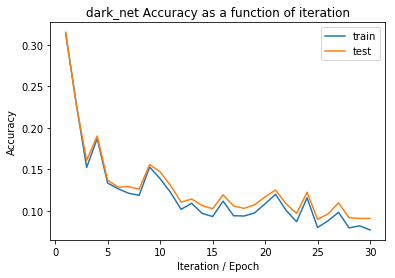

In [5]:
part_d_net = Darknet()
part_d_net.to(device)
part_d_opt = optim.SGD(part_d_net.parameters(), lr=0.0001, momentum=0.05)
train(part_d_net, part_d_opt, graph_title='dark_net', num_epoch=30, print_interval=100)

In [6]:
train_accu = get_accuracy(part_d_net, trainloader)
test_accu = get_accuracy(part_d_net, testloader)
print("train accu", train_accu)
print("test accu", test_accu)

train accu tensor(0.0790, device='cuda:0', dtype=torch.float64)
test accu tensor(0.0864, device='cuda:0', dtype=torch.float64)


In [7]:
dark_net_path = "darknet_v1"
torch.save(part_d_net.state_dict(), dark_net_path)
# How to load it back. NOTE: the model class should be the SAME!!!!
# part_d_net = DarkNet()
# part_d_net.load_state_dict(torch.load(dark_net_path))

# Simple Net

In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.model = self._make_layers_()
        self.fc = nn.Linear(128*2*2, 10)
        
    def forward(self, x):
        print(x.shape)
        x = self.model(x)
        
        # FC, 2 * 2 * 128
        print(x.shape)
        sys.exit(1)
        x = x.view(-1, 128*2*2)
        x = F.relu(self.fc(x))
        
        return x
        
    def _make_layers_(self):
        return nn.Sequential(
            # layer 1
            nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(64, momentum = 0.05),
            nn.ReLU(),
            
            # layer 2 --1
            nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            # layer 2 --2
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            # layer 2 --3
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)), 
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            nn.MaxPool2d([2, 2], stride=(2, 2)),
            nn.Dropout(p=0.2),
            
            # layer 5 --1
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            # layer 5 --2
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            # layer 7
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            nn.MaxPool2d([2, 2], stride=(2, 2)),
            nn.Dropout(p=0.2),
            
            # layer 8 --1
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            # layer 8 --2
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            nn.MaxPool2d([2, 2], stride=(2, 2)),
            nn.Dropout(p=0.2),
            
            # layer 10
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            # layer 11
            nn.Conv2d(128, 128, kernel_size=[1, 1], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            # layer 12
            nn.Conv2d(128, 128, kernel_size=[1, 1], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            nn.MaxPool2d([2, 2], stride=(2, 2)),
            nn.Dropout(p=0.2),
            
            # layer 13
            nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, momentum = 0.05),
            nn.ReLU(),
            
            nn.MaxPool2d([2, 2], stride=(2, 2)),
            
            nn.Dropout(p=0.2)
        )

In [0]:
part_c_net = SimpleNet()
part_c_net.to(device)

In [0]:
part_c_opt = optim.SGD(part_c_net.parameters(), lr=0.0001, momentum=0)

In [0]:
# part_c_net = SimpleNet()
# part_c_net.to(device)
# part_c_opt = optim.SGD(part_c_net.parameters(), lr=0.0001, momentum=0)
train(part_c_net, part_c_opt, graph_title='simple_net', num_epoch=30, print_interval=100)

# Deeper Model

In [4]:
class DeeperNet(nn.Module):
    def __init__(self):
        super(DeeperNet, self).__init__()
        self.model = self._make_layers_()

        self._fc_sz = 20 * 10 * 10
        self.fc = nn.Linear(self._fc_sz, 1)
    
    def forward(self, x):
        x = self.model(x)

        # print("before fc size", x.shape)
        # sys.exit(1)
        x = x.view(-1, self._fc_sz)
        x = F.relu(self.fc(x))

        return x

    def _make_layers_(self):
        return nn.Sequential(

            # layer 1
            nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(10),
            nn.MaxPool2d(3, stride=3),
            nn.ReLU(),

            # layer 2
            nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(5, stride=5),
            nn.ReLU(),

            # layer 3
            nn.Conv2d(20, 20, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(20),
            nn.MaxPool2d(5, stride=5),
            nn.ReLU(),

        )

HI
Epoch 0
[1,   100] loss: 0.392
[1,   200] loss: 0.361
[1,   300] loss: 0.328
[1,   400] loss: 0.305
[1,   500] loss: 0.307
[1,   600] loss: 0.318
[1,   700] loss: 0.271
[1,   800] loss: 0.293
[1,   900] loss: 0.252
[1,  1000] loss: 0.262
[1,  1100] loss: 0.247
[1,  1200] loss: 0.260
[1,  1300] loss: 0.249
[1,  1400] loss: 0.248
[1,  1500] loss: 0.241
[1,  1600] loss: 0.231
[1,  1700] loss: 0.227
[1,  1800] loss: 0.218
[1,  1900] loss: 0.213
[1,  2000] loss: 0.227
Epoch 1
[2,   100] loss: 0.205
[2,   200] loss: 0.214
[2,   300] loss: 0.214
[2,   400] loss: 0.197
[2,   500] loss: 0.226
[2,   600] loss: 0.189
[2,   700] loss: 0.202
[2,   800] loss: 0.199
[2,   900] loss: 0.207
[2,  1000] loss: 0.189
[2,  1100] loss: 0.196
[2,  1200] loss: 0.204
[2,  1300] loss: 0.190
[2,  1400] loss: 0.202
[2,  1500] loss: 0.190
[2,  1600] loss: 0.196
[2,  1700] loss: 0.201
[2,  1800] loss: 0.186
[2,  1900] loss: 0.185
[2,  2000] loss: 0.201
Epoch 2
[3,   100] loss: 0.188
[3,   200] loss: 0.173
[3,   3

(0.0, 0.0)

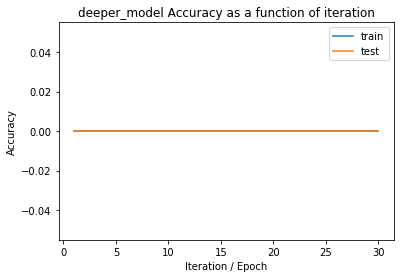

In [5]:
part_b_net = DeeperNet()
part_b_net.to(device)
part_b_opt = optim.SGD(part_b_net.parameters(), lr=0.0001, momentum=0)
train(part_b_net, part_b_opt, graph_title='deeper_model', num_epoch=30, print_interval=100)


In [19]:
# Save this working model.
deeper_net_path = "deepernet.torch"
torch.save(part_b_net.state_dict(), deeper_net_path)
# How to load it back. NOTE: the model class should be the SAME!!!!
# part_b_net = DeeperNet()
# part_b_net.load_state_dict(torch.load(deeper_net_path))

## Simpliest Model

In [4]:
class FC_No_Hidden(nn.Module):
    def __init__(self):
        super(FC_No_Hidden, self).__init__()
        self.fc1 = nn.Linear(800*800*3, 1)

    def forward(self, x):
        # first transform to long vector then output through linear
        x = x.view(-1, 800*800*3)
        x = self.fc1(x)
        # squeeze the dimension
        x = x.view(x.size(0), -1)
        return x

In [5]:
part_a_net = FC_No_Hidden()
part_a_net.to(device)
part_a_opt = optim.SGD(part_a_net.parameters(), lr=0.00001, momentum=0)
train(part_a_net, part_a_opt, graph_title='simpliest_model', num_epoch=30, print_interval=100)

HI
Epoch 0
iter 0 loss 0.3730698823928833
iter 1 loss 4.005115509033203
iter 2 loss 61.52337646484375
iter 3 loss 888.7198486328125
iter 4 loss 13382.470703125
iter 5 loss 224991.359375
iter 6 loss 4239744.0
iter 7 loss 74775160.0
iter 8 loss 1077042688.0
iter 9 loss 12655656960.0
iter 10 loss 164620009472.0
iter 11 loss 2449315987456.0
iter 12 loss 41244558360576.0
iter 13 loss 436946786582528.0
iter 14 loss 4855126594420736.0


KeyboardInterrupt: 